# 2D FNO for Darcy Flow Prediction
---
**Authors**: Xuesong (Cedar) Ma, Bernard Chang, and Masa Prodanovic

Last Updated: Apr. 30, 2025

## Objective
In this notebook, we will train a ***Fourier Neural Operator (FNO)*** to predict the 2D pressure field as described by Darcy's equation.

### Darcy Flow Formulation

Darcy's equation describes the flow of a fluid through a porous medium using a simple relationship between flow rate and pressure drop. Given a permeability field, $k$, and fluid dynamic viscosity $\mu$, we can derive:

$q = -\frac{k}{\mu} \nabla p$,

where $q$ is the volumetric flux (Darcy flux) and $\nabla p$ is the hydraulic gradient. 

The fluid velocity, $v_f$, can be recovered by rescaling the Darcy flux by the porosity, $\phi$,

$v_f = \frac{q}{\phi}$.

By considering incompressibility ($\nabla \cdot v_f = 0$) and constant fluid density and constant porosity, we obtain the Poisson equation to express the fluid pressure field,

$\nabla \cdot (-\frac{k}{\mu} \nabla p) = 0$

### FNO Data
We solve this form of the Darcy equation for the steady-state pressure field using the open-source [FEniCS](https://fenicsproject.org/) software package. 

The input to the solver (and to the FNO) is the permeability field, generated as a Gaussian random field with varying correlation lengths. The output is the pressure field solution.

Training image sizes are $64\times64$, but we will test FNO resolution invariance with image sizes ranging from $32\times32$ to $256\times256$. 











In [2]:
import torch
import numpy as np
import lightning as pl
from torch.utils.data import DataLoader, random_split

from FNO2d import FNO2d
from dataloading import DarcyDataset
from lightning.pytorch.loggers  import TensorBoardLogger
# from train_utils import LiveLossPlotter

import matplotlib.pyplot as plt

In [3]:
dataset = DarcyDataset('darcy_data_res.h5', resolution='resolution_64')

# Specify the sizes of your splits
train_size = int(0.7 * len(dataset))  # 70% for training
val_size = int(0.15 * len(dataset))   # 15% for validation
test_size = len(dataset) - train_size - \
    val_size  # Remaining 15% for testing

# Split the dataset into training, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size])


# Create DataLoaders for each split
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)




In [4]:
# Initialize logger
# Training the model
modes1, modes2, width = 8, 8, 64  # example values for modes and width
num_layers = 4
model = FNO2d(modes1=modes1, modes2=modes2, width=width, num_layers=num_layers)

# Train the model using PyTorch Lightning Trainer
# Set gpus=1 if you want to use GPU


trainer = pl.Trainer(max_epochs=50, 
                     strategy='auto', 
                     check_val_every_n_epoch=10,
                     log_every_n_steps=35)



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
# # Start TensorBoard to visualize the logs (only once)
# %load_ext tensorboard

# # Launch TensorBoard for real-time updates during training
# %tensorboard --logdir logs/darcy_fno


In [5]:
trainer.fit(model, train_loader, val_loader)

You are using a CUDA device ('NVIDIA RTX 6000 Ada Generation') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | p          | Linear     | 256   
1 | fno_blocks | ModuleList | 2.1 M 
2 | q1         | Linear     | 8.3 K 
3 | q2         | Linear     | 129   
------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.490     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\ProgramData\anaconda3\envs\ms-fno\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\ProgramData\anaconda3\envs\ms-fno\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

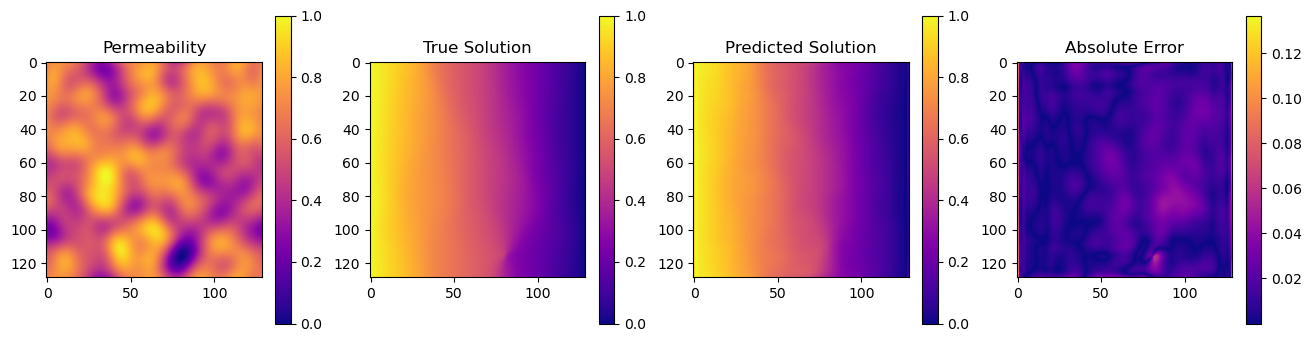

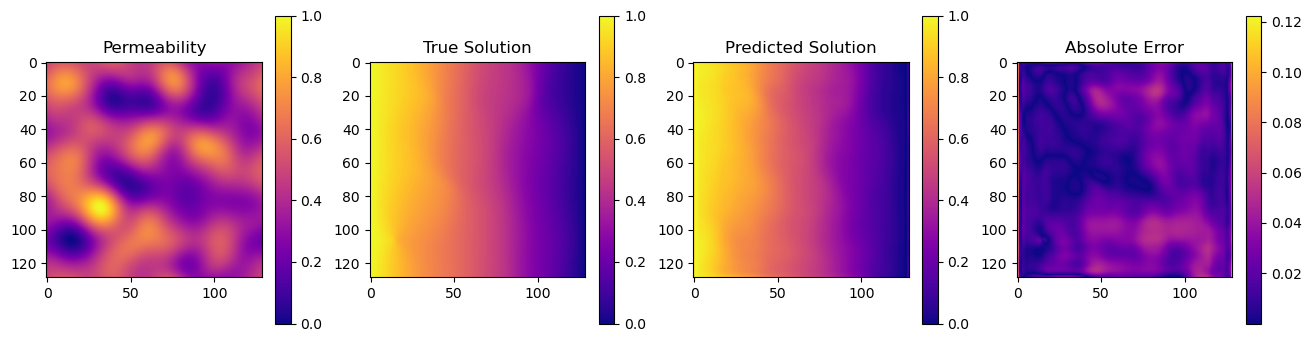

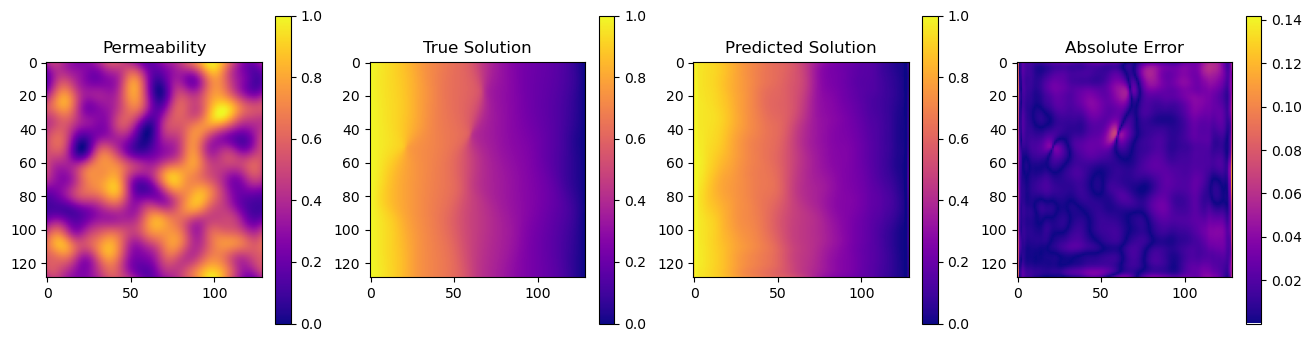

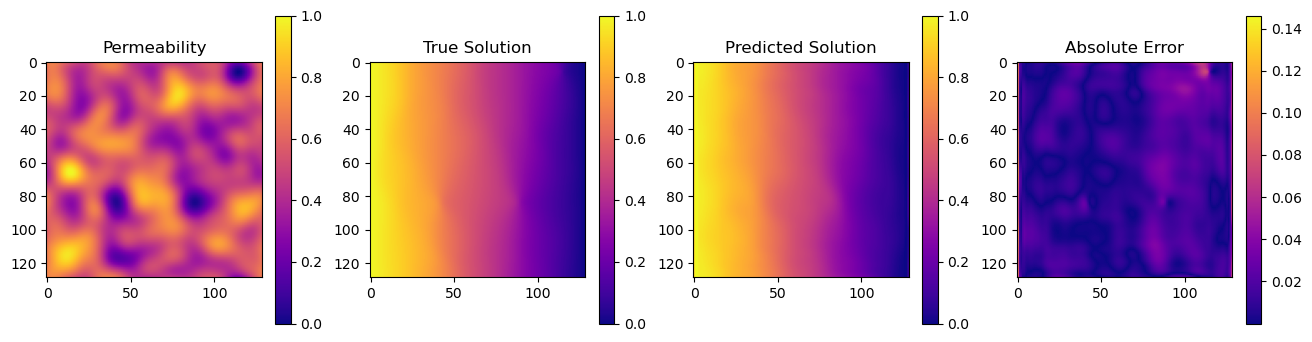

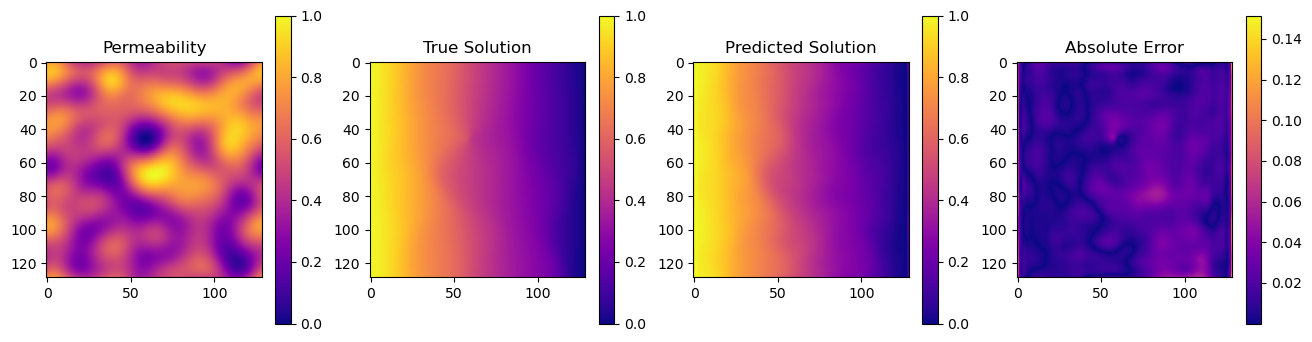

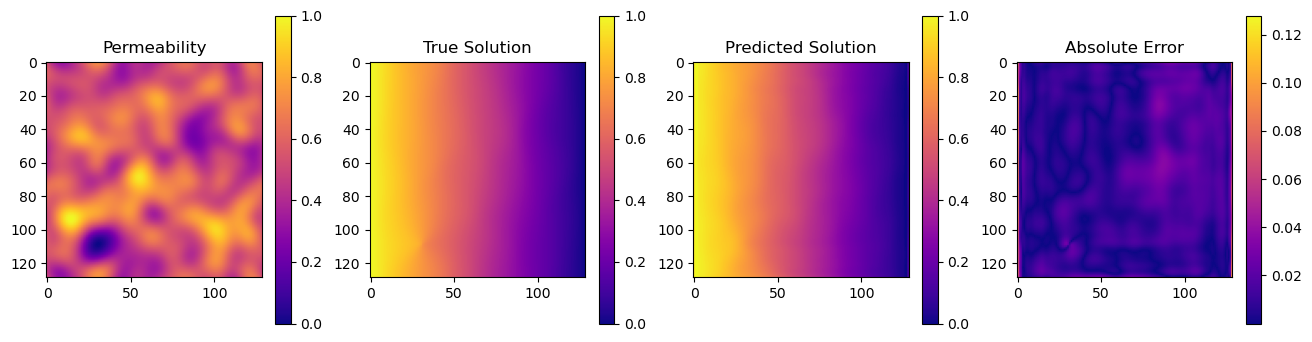

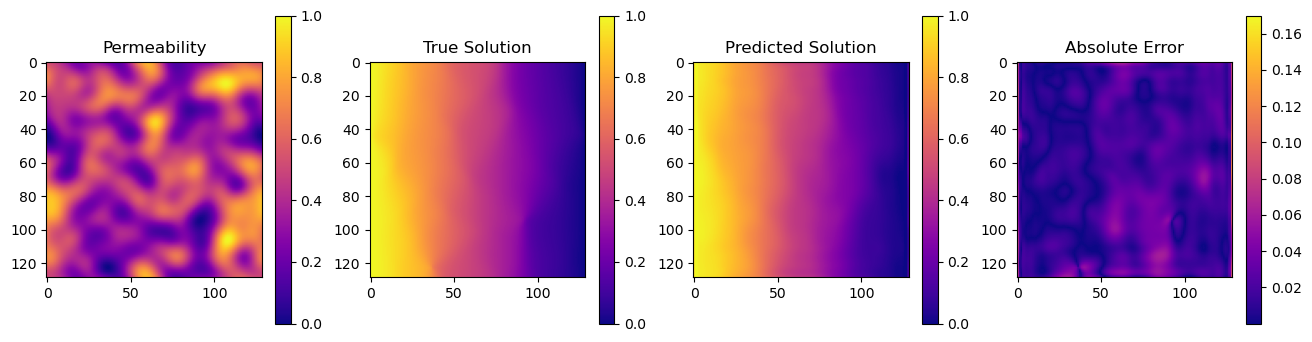

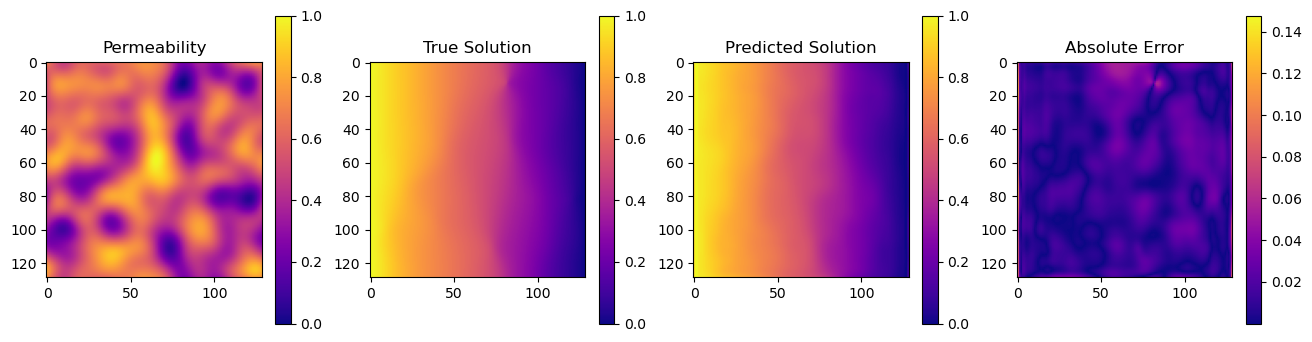

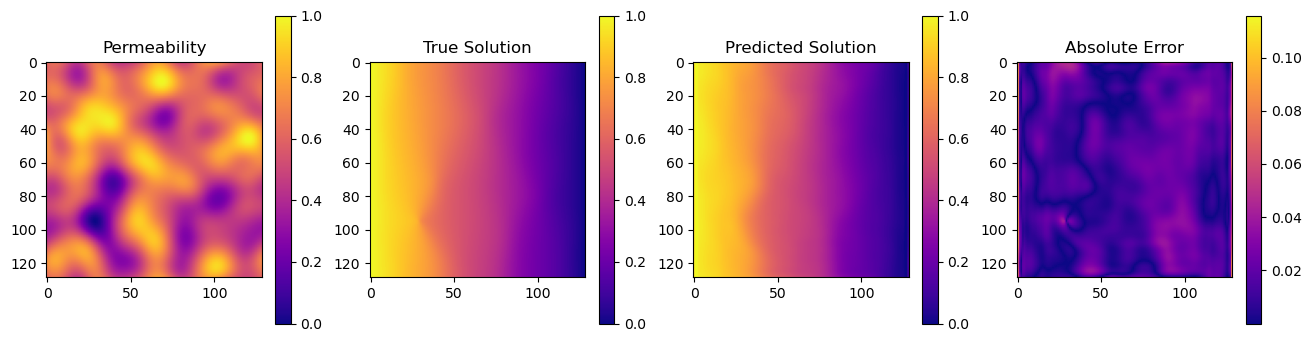

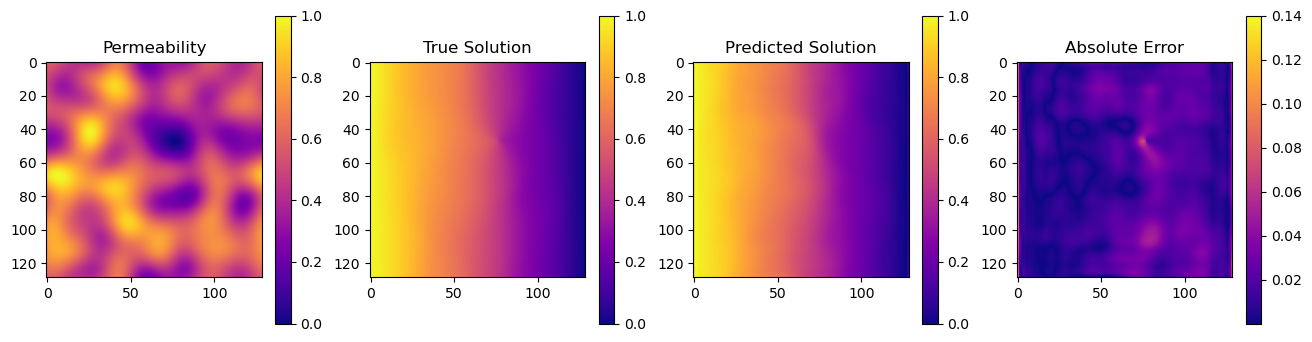

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_loss_epoch      │   0.0004471058491617441   │
└───────────────────────────┴───────────────────────────┘

In [8]:

res_128_dataset = DarcyDataset('darcy_data_fov.h5', resolution='resolution_128')
# subset = torch.utils.data.Subset(res_128_dataset, list(range(10)))
# _, _, test_dataset = random_split(
#     dataset, [0, 0, test_size])
test_loader = DataLoader(res_128_dataset, batch_size=1, shuffle=False)

test_results = trainer.test(model, dataloaders=test_loader)
